# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a GRU unit.
Gated Recurrent Units are one kind of RNNs. 

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
! git clone https://github.com/pierinim/tutorials.git

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [4]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


# Building the RNN model

In [7]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

2024-05-13 16:29:21.522347: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 16:29:21.523804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 16:29:21.548727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 16:29:21.548752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 16:29:21.548774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [8]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [9]:
####
inputList = Input(shape=(featureArrayLength))
x = GRU(40, activation="tanh", recurrent_activation='sigmoid')(inputList)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 gru (GRU)                   (None, 40)                6960      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0     

We now train the model

In [11]:
batch_size = 128
n_epochs = 20

In [12]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/20
262/262 - 11s - loss: 1.5994 - val_loss: 1.4864 - lr: 0.0010 - 11s/epoch - 41ms/step
Epoch 2/20
262/262 - 9s - loss: 1.4184 - val_loss: 1.3731 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 3/20
262/262 - 9s - loss: 1.3752 - val_loss: 1.3495 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 4/20
262/262 - 10s - loss: 1.3615 - val_loss: 1.3350 - lr: 0.0010 - 10s/epoch - 37ms/step
Epoch 5/20
262/262 - 9s - loss: 1.3480 - val_loss: 1.3206 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 6/20
262/262 - 9s - loss: 1.3381 - val_loss: 1.3179 - lr: 0.0010 - 9s/epoch - 35ms/step
Epoch 7/20
262/262 - 9s - loss: 1.3251 - val_loss: 1.3118 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 8/20
262/262 - 10s - loss: 1.3203 - val_loss: 1.3070 - lr: 0.0010 - 10s/epoch - 36ms/step
Epoch 9/20
262/262 - 9s - loss: 1.3172 - val_loss: 1.3100 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 10/20
262/262 - 9s - loss: 1.3137 - val_loss: 1.3048 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 11/20
262/262 - 10s - loss: 1.3099 - val_loss: 

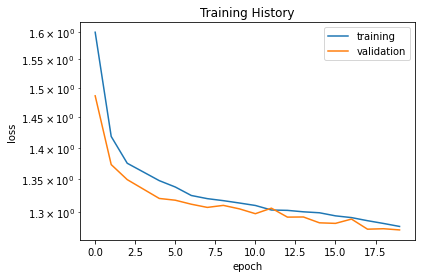

In [13]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [14]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 5s 9ms/step


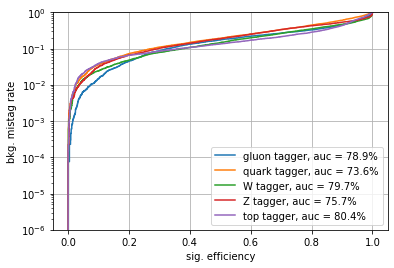

In [15]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

## plot probability for all taggers

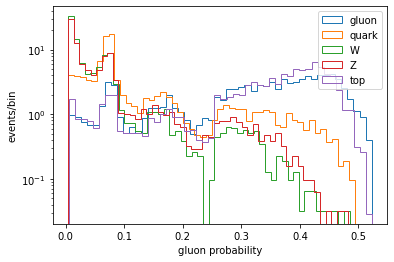

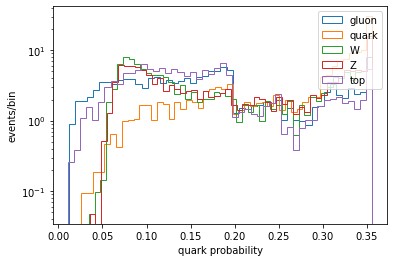

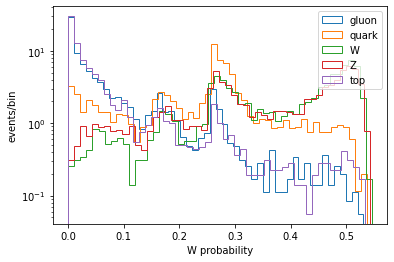

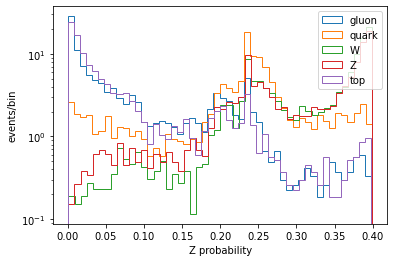

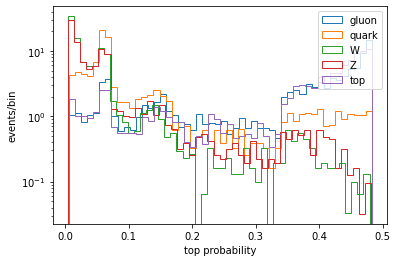

In [16]:
df1=pd.DataFrame()
for i, label in enumerate(labels):
    df1[label] = y_val[:,i]
    df1[label + '_pred'] = predict_val[:,i]
for i, label in enumerate(labels):
    labp=label + '_pred'
    for j, label in enumerate(labels):
       plt.hist(df1.query(label+'==1')[labp],50,density=True, histtype='step',label=label)
    plt.semilogy()
    plt.xlabel(labels[i]+' probability')
    plt.ylabel("events/bin")
    plt.legend(loc='best')
    plt.show()        